In [1]:
%load_ext autotime
import pymongo
import json
import copy
import math
import time
from tqdm import tqdm_notebook, tnrange
from graphviz import Graph

## Connect to the database

In [2]:
# create connecttion with database
# Note: to connect to your own db, change the url and port number
# Also change the authenticate
client = pymongo.MongoClient('mongodb://ds121163.mlab.com',21163)
# Get the database
jasondb = client['jasondb']
# Set authentication
jasondb.authenticate('admin','admin123')
# Get collection, if no named collection then create one
companies = jasondb.bigquery 
# name of the output file

OUTPUT_FILE_NAME = 'output.json'


time: 328 ms


## Upload data

In [ ]:
with open('results-20190219-203953.json') as f:
    file_data = json.load(f)
companies.insert(file_data)


In [ ]:
# following code is to load json file to mongodb

file = open('results-20190219-203352.json',encoding='utf8')
maxNum = 100
currentNum = 0
for line in file:
    if currentNum >= maxNum:
        break
    print(line)
    data = json.loads(line.replace("$",""))
    print(data)
    companies.insert_one(data)
    currentNum += 1
file.close()

## Check number of schema and get r-schema

In [3]:
# a function to create rscheme
# it require a document and a path to this document
# typ of the document should be dict
def createRschema (rscheme, document, path):
    # define a rscheme
    # get keys
    for key in document:
        # check if the path is root or not
        # if not, add .
        if path == "":
            currentPath = key
        else:
            # for this collections ONLY
            # In this collections it has a list as a key
            if(isinstance(key, list)):
                currentPath = path + "." + covertListToString(key)
            else:
                currentPath = path + "." + key
        # add to dict
        rscheme[currentPath] = type(document.get(key)).__name__
        # recursion call
        if isinstance(document.get(key), list):
            for element in document.get(key):
                if isinstance(element, list):
                    break
                else:
                    createRschema(rscheme, element, currentPath)
        elif isinstance(document.get(key),dict):
            createRschema(rscheme, document.get(key),currentPath)

time: 3 ms


In [4]:
# A helper function to convert list to string
def covertListToString (lst):
    str = '['
    for i in lst:
        str+' , '
    str+']'
    return str


time: 989 µs


In [5]:
# get document in the collection and parse them
rscheme = {}
for document in companies.find({}):
    createRschema(rscheme, document, "")

# output to a file
with open(OUTPUT_FILE_NAME,'w') as output:
     json.dump(rscheme, output, sort_keys=TabError, indent= 4)

print(len(rscheme))
print(rscheme)

7
{'_id': 'ObjectId', 'image_id': 'str', 'subset': 'str', 'original_url': 'str', 'source': 'str', 'label_name': 'str', 'confidence': 'str'}
time: 440 ms


### Get Number of Schemas

In [6]:

def getNumOfScheme (rscheme, document, path = '', added = False):
    # define a rscheme
    # get keys
    for key in document:
        # check if the path is root or not
        # if not, add .
        if path == "":
            currentPath = key
        else:
            # for this collections ONLY
            # In this collections it has a list as a key
            if(isinstance(key, list)):
                currentPath = path + "." + covertListToString(key)
            else:
                currentPath = path + "." + key
        # add to dict
        datatype = type(document.get(key)).__name__
        if not 'dict' in datatype and not 'list' in datatype:
            datatype = 'primary'
        if currentPath not in rscheme:
            rscheme[currentPath] = datatype
            if added==False:
                global numOfScheme
                numOfScheme += 1
                added = True
        
        # recursion call
        if isinstance(document.get(key), list):
            for element in document.get(key):
                if isinstance(element, list):
                    break
                else:
                    getNumOfScheme(rscheme, element, currentPath, added)
        elif isinstance(document.get(key),dict):
            getNumOfScheme(rscheme, document.get(key),currentPath, added)

time: 3.03 ms


In [7]:
def checkIfHave(schemas, rschemas):
    for schema in schemas:
        if schema == rschemas:
            return True
    return False

time: 1 ms


In [8]:
# We need to count how many distinct schema in a collection
# Different path, and datatype

#def getNumofSchema (document, path)
schemas = []
numOfScheme = 0
count = 0
datas=[]
for document in companies.find({}):
    rscheme = {}
    datas.append(document)
    count += 1
    getNumOfScheme(rscheme, document)
    if not checkIfHave(schemas, rscheme):
        schemas.append(rscheme)
        
print("number of schemas:" , len(schemas))
print("number of documents:" , count)
print(schemas)


number of schemas: 2
number of documents: 4000
[{'_id': 'primary', 'image_id': 'primary', 'subset': 'primary', 'original_url': 'primary'}, {'_id': 'primary', 'image_id': 'primary', 'source': 'primary', 'label_name': 'primary', 'confidence': 'primary'}]
time: 376 ms


## Tree

In [9]:
class DecisionTree():
    def __init__(self):
        self.nodes = []
        self.edges = []
        self.entropy = 0
        self.schemaentropy = 0
        self.leafid=0
    def addNode (self, newNode, parent = None, value = None):
        self.nodes.append(newNode)
        if parent is not None and value is not None:
            temp = Edge(paren, newNode, value)
            for edge in self.edges:
                if not edge == temp:
                    self.edges.append(temp)
    def split(self, node,key, nodeList, isPure):
        
        newNode = Node(key)
        if len(self.nodes)==1:
            if node in self.nodes:
                self.nodes.remove(node)
                self.nodes.append(newNode)
                
                for leaf in nodeList:
                    leaf.canBeSplit = isPure
                    leaf.id = self.leafid
                    self.leafid = self.leafid + 1
                    self.nodes.append(leaf)
                    temp = Edge(newNode, leaf, leaf.value, leaf.symbol)
                    self.edges.append(temp)
        else:
            if node in self.nodes:
                self.nodes.remove(node)
                self.nodes.append(newNode)
                for edge in self.edges:
                    if edge.contain(node):
                        edge.children = newNode
                for leaf in nodeList:
                    leaf.canBeSplit = isPure
                    leaf.id = self.leafid
                    self.leafid = self.leafid + 1
                    self.nodes.append(leaf)
                    temp = Edge(newNode, leaf, leaf.value, leaf.symbol)
                    self.edges.append(temp)
                    
    def display(self):
        for node in self.nodes:
            print(node.name)
        for edge in self.edges:
            print(edge.value)
            
            
        
class Node():
    def __init__(self, name):
        self.name = name
        self.children = []
    def addChild(self, obj):
        self.children.append(obj)
    def __eq__(self, other):
        if isinstance(other, Node):
            return self.name == other.name
        return False
    
class Leaf(Node):
    def __init__(self, schemas, value, symbol, name = 'leaf'):
        self.schemas = schemas
        self.name = name
        self.canBeSplit = True
        self.value = value
        self.symbol = symbol
        self.id=''
    def getSchemas(self):
        return self.schemas        
        
class Edge():
    def __init__(self, parent, children, value, symbol):
        self.parent = parent
        self.children = children
        self.value = value
        self.symbol = symbol
    def __eq__(self, other):
        if isinstance(other, Edge):
            return (self.children == other.childre) and (self.parent == other.paren) and (self.value == other.value)
        return False
    def contain(self, node):
        if self.children == node:
            return True
        else:
            return False

time: 10 ms


In [10]:
def mergeSchemas(schemas):
    rschemas ={}
    for schema in schemas:
        for key, value in schema.items():
            if key in rschemas and not value == rschemas[key]:
                rschemas[key] = 'str'
            else:
                rschemas[key] = value
    return rschemas

time: 1 ms


In [11]:
# Numeric split can be <= and >
def numeric(node, key, value):
    less = Leaf([], value, 'less')
    greater = Leaf([],value, 'greater')
    # Get nodeList after split
    nodeList = [Leaf([],value, 'equal'), Leaf([],value,'notEqual')]
    # get associated schema and split them
    for data in datas:
        rscheme = {}
        getNumOfScheme (rscheme, data)
        if getValue(data, key.split('.')) <= value:
            if not checkIfHave(less.schemas, rscheme):
                less.schemas.append(rscheme)
        else:
            if not checkIfHave(greater.schemas, rscheme):
                greater.schemas.append(rscheme)
        if getValue(data, key.split('.')) == value:
            if not checkIfHave(nodeList[0].schemas, rscheme):
                nodeList[0].schemas.append(rscheme)
        else:
            if not checkIfHave(nodeList[1].schemas, rscheme):
                nodeList[1].schemas.append(rscheme)

    # calculate entropy:
    lessEntropy = 0
    greaterEntropy = 0
    lessTotal = 0
    greaterTotal = 0
    
    for schema in less.schemas:
        lessTotal = lessTotal + len(schema)
    for schema in greater.schemas:
        greaterTotal = greaterTotal + len(schema)
    # calculate schema-entropy3
    sEntropy = 0
    totalLength = lessTotal+greaterTotal
    for schema in node.schemas:
        
        if schema in less.schemas and schema in greater.schemas:
            lessEntropy = lessEntropy - len(schema)/(lessTotal)* math.log10(len(schema)/lessTotal)
            greaterEntropy = greaterEntropy - len(schema)/(greaterTotal)* math.log10(len(schema)/greaterTotal)
        elif schema in less.schemas and schema not in greater.schemas:
            lessEntropy = lessEntropy - len(schema)/(lessTotal)* math.log10(len(schema)/lessTotal)
        elif schema not in less.schemas and schema in greater.schemas:
            greaterEntropy = greaterEntropy - len(schema)/(greaterTotal)* math.log10(len(schema)/greaterTotal)
        if schema in less.schemas and schema in greater.schemas:
            temp = len(schema)/(2*len(schema))* math.log10(len(schema)/(2*len(schema)))+ len(schema)/(2*len(schema))* math.log10(len(schema)/(2*len(schema)))
            sEntropy = sEntropy - 2*len(schema)/totalLength * temp
        elif schema in less.schemas and schema not in greater.schemas:
            temp = len(schema)/(len(schema))* math.log10(len(schema)/(len(schema)))
            sEntropy = sEntropy - len(schema)/totalLength * temp
        elif schema not in less.schemas and schema in greater.schemas:
            temp = len(schema)/(len(schema))* math.log10(len(schema)/(len(schema)))
            sEntropy = sEntropy - len(schema)/totalLength * temp
    entropy = lessEntropy * len(less.schemas) /(len(less.schemas)+len(greater.schemas)) + greaterEntropy * len(greater.schemas) /(len(less.schemas)+len(greater.schemas))  
    
     # calculate entropy and sEntropy
    entropyCategorical1, sEntropyCategorical1 = entropysCalculation(nodeList,node.schemas)
    
    if sEntropy< sEntropyCategorical1:
        return entropy,sEntropy, [less, greater]
    elif sEntropy == sEntropyCategorical1 and entropy>entropyCategorical1:
        return entropy,sEntropy, [less, greater]
    else:
        return entropyCategorical1,sEntropyCategorical1, nodeList



def categorical2(node, key, values):
    # Get nodeList after split
    nodeList = []
    for value in values:
        schemas = []
        for data in datas:
            rscheme = {}
            getNumOfScheme (rscheme, data)
            if getValue(data, key.split('.')) == value:
                if not checkIfHave(schemas, rscheme):
                    schemas.append(rscheme)
        nodeList.append(Leaf(schemas, value, 'equal'))
    
    # calculate entropy and sEntropy
    entropy, sEntropy = entropysCalculation(nodeList,node.schemas)
                
    return entropy, sEntropy, nodeList

time: 11 ms


In [12]:
def entropysCalculation(nodeList, schemas):
    entropy = 0
    total = 0
    sEntropy = 0
    for node in nodeList:
        for schema in node.schemas:
            total = total + len(schema)
            
    for node in nodeList:
        temp = 0
        totalAttributeInThisLeaf = 0
        for schema in node.schemas:
            totalAttributeInThisLeaf = totalAttributeInThisLeaf + len(schema)
        for schema in node.schemas:
            temp = temp - len(schema)/totalAttributeInThisLeaf*math.log10(len(schema)/totalAttributeInThisLeaf)
        entropy = entropy + temp * totalAttributeInThisLeaf/total
        
    for schema in schemas:
        temp = 0
        totalForThisSchema = 0
        for node in nodeList:
            if checkIfHave(node.schemas, schema):
                totalForThisSchema = totalForThisSchema + len(schema)
        for node in nodeList:
            if checkIfHave(node.schemas, schema):
                temp = temp + len(schema)/totalForThisSchema * math.log10(len(schema)/totalForThisSchema)
        sEntropy = sEntropy - temp * totalForThisSchema/total
    return entropy, sEntropy

time: 3 ms


In [13]:
def getValue(currentData, path):
    if len(path) == 1:
        key = path.pop()
        if key in currentData:
            return currentData[key]
        else:
            return None
    else:
        return getValue(currentData[path.pop()], path)
    

time: 998 µs


In [14]:
# find the best splict for an attributes
# decisionTree: Current dicisionTree before split
# node: The node you want to split
# key: The attribute that you want to split
# return: bestsplit entropy value, schema entropy value and new Decision tree
def findBestSplitValueBased(decisionTree, node, key):
    tempTree = copy.deepcopy(decisionTree)
    # Get distinct values
    values = []
    for data in datas:
        temp = getValue(data, key.split('.'))
        if temp is not None:
            values.append(temp)
    values = list(set(values))
    values.sort()
    currentBestEntropy =  0
    currentBestSchemaEntropy =  99999
    nodeList = []
    # Check numeric split
    for i in tqdm_notebook(range(0,len(values)-1), desc='numeric split'):
        # Get value for this index split
        tempEntropy, tempSchemaEntropy, tempNodeList = numeric(node, key, values[i])
        
        if tempSchemaEntropy < currentBestSchemaEntropy:
            currentBestEntropy = tempEntropy
            currentBestSchemaEntropy = tempSchemaEntropy
            nodeList = tempNodeList
        elif tempSchemaEntropy == currentBestSchemaEntropy and tempEntropy > currentBestEntropy:
            currentBestEntropy = tempEntropy
            currentBestSchemaEntropy = tempSchemaEntropy
            nodeList = tempNodeList
            
    # Get value for categorical 2 split
    tempEntropy, tempSchemaEntropy,tempNodeList = categorical2(node, key, values)
        
    if tempSchemaEntropy < currentBestSchemaEntropy:
        currentBestEntropy = tempEntropy
        currentBestSchemaEntropy = tempSchemaEntropy
        nodeList = tempNodeList
    elif tempSchemaEntropy == currentBestSchemaEntropy and tempEntropy > currentBestEntropy:
        currentBestEntropy = tempEntropy
        currentBestSchemaEntropy = tempSchemaEntropy
        nodeList = tempNodeList
        
    return currentBestEntropy, currentBestSchemaEntropy, nodeList

time: 4.98 ms


In [15]:
def getIntersectionOfSchemas(schemas):
    # get intersection keys
    keys = set(schemas[0].keys())
    for schema in schemas:
        temp = set(schema.keys())
        keys = temp & keys
    intersectionOfSchemas = {}
    for key in keys:
        for schema in schemas:
            if key in intersectionOfSchemas and not intersectionOfSchemas[key] == schema[key]:
                intersectionOfSchemas.pop(key)
            elif key not in intersectionOfSchemas:
                intersectionOfSchemas[key] = schema[key]
    return intersectionOfSchemas
def getDistinctAttributes(schemas, intersectionAttributes):
    attributes = {}
    for schema in schemas:
        for key, value in schema.items():
            if key not in intersectionAttributes:
                attributes[key]= value
    return attributes

time: 2.03 ms


In [16]:
def findBestSplitSchemaBased(decisionTree, node, key):
    nodeList=[Leaf([], key, 'E'), Leaf([],key,'notE')]
    for schema in node.schemas:
        if key in schema:
            if not checkIfHave(nodeList[0].schemas, schema):
                nodeList[0].schemas.append(schema)
        else:
            if not checkIfHave(nodeList[1].schemas, schema):
                nodeList[1].schemas.append(schema)
    
    
    # calculate entropy and sEntropy
    entropy, sEntropy = entropysCalculation(nodeList,node.schemas)
    
    return entropy, sEntropy, nodeList
         

time: 2 ms


In [17]:
def split(decisionTree, node, entropy, sEntropy):
    bestSplit = []
    schemas = node.getSchemas()
    # Get distinct intersection attributes
    intersectionAttributes = getIntersectionOfSchemas(node.getSchemas())
    
    # For each attribute, try to find the best split
    currentBestEntropy =  0
    currentBestSchemaEntropy =  99999
    nodeList = []
    bestAttribute=None
    for key, value in tqdm_notebook(intersectionAttributes.items(),desc='primary type'):
        # check the value based split for primary attributes
        if value == 'primary':
            # find the best split for this attribute
            tempEntropy, tempSchemaEntropy, tempNodeList = findBestSplitValueBased(decisionTree, node, key)
            # check current best
            if tempSchemaEntropy < currentBestSchemaEntropy:
                currentBestEntropy = tempEntropy
                currentBestSchemaEntropy = tempSchemaEntropy
                nodeList = tempNodeList
                bestAttribute = key
            elif tempSchemaEntropy == currentBestSchemaEntropy and tempEntropy > currentBestEntropy:
                currentBestEntropy = tempEntropy
                currentBestSchemaEntropy = tempSchemaEntropy
                nodeList = tempNodeList

    gain = entropy - currentBestEntropy
    loss = currentBestSchemaEntropy - sEntropy
    # if no vaild value split
    if not gain >= alpha or not loss <= beta:
        # Get distinct attributes without intersections
        distinctAttributes = getDistinctAttributes(node.getSchemas(), intersectionAttributes)
        for key, value in distinctAttributes.items():
            # find the best split for this attribute
            tempEntropy, tempSchemaEntropy, tempNodeList = findBestSplitSchemaBased(decisionTree, node, key)
            print("entropy: ", tempEntropy)
            print('sEntropy: ',tempSchemaEntropy)
            # check current best
            if tempSchemaEntropy < currentBestSchemaEntropy:
                currentBestEntropy = tempEntropy
                currentBestSchemaEntropy = tempSchemaEntropy
                nodeList = tempNodeList
                bestAttribute = key
            elif tempSchemaEntropy == currentBestSchemaEntropy and tempEntropy > currentBestEntropy:
                currentBestEntropy = tempEntropy
                currentBestSchemaEntropy = tempSchemaEntropy
                nodeList = tempNodeList
                bestAttribute = key
        
        gain = entropy - currentBestEntropy
        loss = currentBestSchemaEntropy - sEntropy
        print(gain)
        print(loss)
        print(key)
        # if also no schema split
        if (not gain >= alpha or not loss <= beta) and not loss == 0:
            for tempNode in decisionTree.nodes:
                if tempNode == node:
                    node.canBeSplit = False
            return
    
    
    #rebuild the tree
    decisionTree.split(node,key, nodeList, False)

    for node in decisionTree.nodes:
        if type(node).__name__ == 'Leaf' and node.canBeSplit == True:
            split(decisionTree, node, currentBestEntropy, currentBestSchemaEntropy)
    


time: 7 ms


In [18]:
schemaProfiling = DecisionTree()
root = Leaf(schemas,'','')
schemaProfiling.addNode(root)

time: 1.03 ms


In [19]:
alpha = 0.1
beta = 0.01
entropy, sEntropy = entropysCalculation([root], root.schemas)
split(schemaProfiling,root,entropy,sEntropy)
print("done")



done
time: 4min 37s


In [96]:
for node in schemaProfiling.nodes:
    if type(node).__name__ == 'Leaf':
        print(node.name)
        print(node.schemas)
for edge in schemaProfiling.edges:
    print(edge.parent.name)
    print(edge.children.name)
    print(edge.value)
    print(edge.symbol)
    

leaf
[{'_id': 'primary', 'image_id': 'primary', 'subset': 'primary', 'original_url': 'primary'}]
leaf
[{'_id': 'primary', 'image_id': 'primary', 'source': 'primary', 'label_name': 'primary', 'confidence': 'primary'}]
_id
leaf
5c6cafbed1823d09746e36b2
less
_id
leaf
5c6cafbed1823d09746e36b2
greater
time: 24 ms


## Visulization

In [20]:
import pydot

time: 77 ms


In [21]:
G = pydot.Dot()

time: 2 ms


In [22]:
for node in schemaProfiling.nodes:
    if type(node).__name__ == 'Leaf':
        temp = pydot.Node(node.id, label=''.join(json.dumps(node.schemas)))
    else:
        temp = pydot.Node(node.name,label=node.name)
    G.add_node(temp)

time: 9 ms


In [23]:
for edge in schemaProfiling.edges:
    if type(edge.children).__name__=='Leaf':
        temp = pydot.Edge(edge.parent.name, str(edge.children.id), label = edge.symbol)
    else:
        temp = pydot.Edge(edge.parent.name, edge.children.name,label=  edge.symbol)
    G.add_edge(temp)

time: 17 ms


In [24]:
from IPython.display import Image, display

time: 11 ms


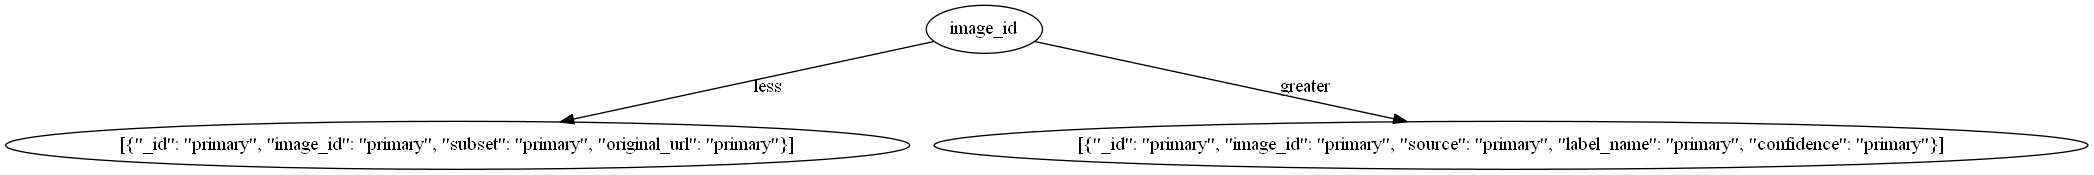

time: 585 ms


In [25]:
im = Image(G.create_png())
display(im)

In [21]:
for node in schemaProfiling.nodes:
    if type(node).__name__ == 'Leaf':
        print(json.dumps(node.schemas))

[{"_id": "primary", "image_id": "primary", "subset": "primary", "original_url": "primary"}]
[{"_id": "primary", "image_id": "primary", "source": "primary", "label_name": "primary", "confidence": "primary"}]
time: 3.99 ms


In [22]:
g = Graph('g', filename='decisionTree.gv')
for node in schemaProfiling.nodes:
    if type(node).__name__ == 'Leaf':
        g.node(str(node.id), ''.join(json.dumps(node.schemas)))
    else:
        g.node(node.name,node.name)
for edge in schemaProfiling.edges:
    if type(edge.children).__name__=='Leaf':
        g.edge(edge.parent.name, str(edge.children.id), edge.symbol)
    else:
        g.edge(edge.parent.name, edge.children.name, edge.symbol)
g.view()

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'decisionTree.gv'], make sure the Graphviz executables are on your systems' PATH

time: 236 ms


## Link to Bigquery and get data

In [ ]:
from google.cloud import bigquery

In [ ]:
def implicit():
    from google.cloud import storage

    # If you don't specify credentials when constructing the client, the
    # client library will look for credentials in the environment.
    storage_client = storage.Client()

    # Make an authenticated API request
    buckets = list(storage_client.list_buckets())
    print(buckets)

In [ ]:
# Set Google application credentials environment
# The path is the path to your key which generated by 
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\Zunchen\Documents\our-lamp-231005-138639b83f6a.json"

In [ ]:
implicit()

In [ ]:
# Instantiates a client
bigquery_client = bigquery.Client()

In [ ]:
# Perform a query.
QUERY = (
    'SELECT * FROM `bigquery-public-data.usa_names.usa_1910_2013` '
    'LIMIT 1')
query_job = bigquery_client.query(QUERY)  # API request
rows = query_job.result()  # Waits for query to finish

for row in rows:
    print(row.name)

In [ ]:
dataset_id = 'bigquery-public-data.usa_names'
dataset_ref = bigquery_client.dataset(dataset_id)
tables = list(bigquery_client.list_tables(dataset_ref))
print(tables)